In [ ]:
# Machine Learning Practical: Coursework 1

**Release date: Monday 10th October 2016**  
**Due date: 16:00 Thursday 27th October 2016**

Instructions for the coursework are [available as a PDF here](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/coursework_1.pdf).

## Part 1: Learning rate schedules

In [1]:
from scipy.ndimage.interpolation import rotate
from mlp.data_providers import AugmentedMNISTDataProvider,MNISTDataProvider
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, TanhLayer, EluLayer, ArcTanLayer, Batch
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import MomentumLearningRule
import numpy as np
import logging
from mlp.optimisers import Optimiser
from collections import OrderedDict
from scipy.ndimage.interpolation import shift


import matplotlib.pyplot as plt

Run Relu Layer
Epoch: 5    OrderedDict([('error(train)', 0.05401618441310229), ('acc(train)', 0.98572000000000481), ('error(valid)', 0.094156406637096027), ('acc(valid)', 0.97360000000000047), ('params_penalty', 0.0)])


In [11]:


models = []
seed = 10102016 
rng = np.random.RandomState(seed)
input_dim, output_dim, hidden_dim = 784, 10, 100
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

"""
,
    (MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ]),'Sigmoid Layer'),
    (MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        TanhLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        TanhLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ]),'TanhLayer Layer'),
    (MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ArcTanLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        ArcTanLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ]),'ArcTanLayer Layer'),
    (MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        EluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        EluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ]),'EluLayer Layer')
"""
model_sets = [
    (MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ]),'Relu Layer')
    
]
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)


run_info = OrderedDict()
for idx, model in enumerate(model_sets):
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    label = model[1]
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print ("Run "+str(label))

    error = CrossEntropySoftmaxError()
    learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    
    optimiser = Optimiser(model[0], error, learning_rule, train_data, valid_data, data_monitors)
    run_info[label] = optimiser.train(num_epochs, stats_interval)






Run Relu Layer
Epoch: 5    OrderedDict([('error(train)', 0.2473741984925705), ('acc(train)', 0.92681999999999998), ('error(valid)', 0.23337658345533832), ('acc(valid)', 0.93289999999999995), ('params_penalty', 0.0)])


KeyboardInterrupt: 

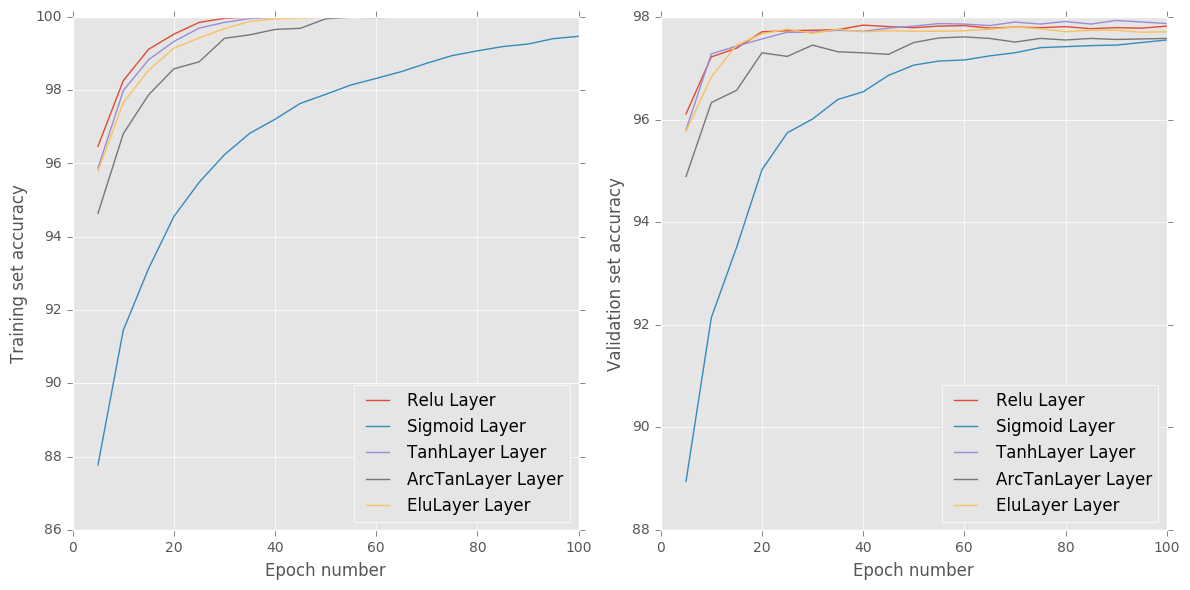

In [3]:

%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for label,run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(train)']]*100, label=str(label))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(valid)']]*100, label=str(label))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set accuracy')
#ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')
#ax2.set_yscale('log')
fig.tight_layout() # This minimises whitespace around the axes.
fig.savefig('models_compare2.pdf') # Save figure to current directory in PDF format

## Part 2: Data augmentaion

In [62]:
from scipy.ndimage.interpolation import rotate
from mlp.data_providers import AugmentedMNISTDataProvider,MNISTDataProvider
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, TanhLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import MomentumLearningRule
import numpy as np
import logging
from mlp.optimisers import Optimiser
from collections import OrderedDict
from scipy.ndimage.interpolation import shift


import matplotlib.pyplot as plt


In [4]:


def random_shift_1(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 1.
    for i, j in enumerate(indices):
        new_ims[j] = shift(orig_ims[j], angles[i], cval=0)
    new_ims[new_ims<0]=0
    return new_ims.reshape((-1, 784))

def random_shift_3(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 3.
    for i, j in enumerate(indices):
        new_ims[j] = shift(orig_ims[j], angles[i], cval=0)
    return new_ims.reshape((-1, 784))

def random_shift_6(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 10.
    for i, j in enumerate(indices):
        new_ims[j] = shift(orig_ims[j], angles[i], cval=0)
    return new_ims.reshape((-1, 784))

In [19]:
def random_rotation(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
    return new_ims.reshape((-1, 784))

In [20]:
from __future__ import print_function
from skimage.transform import rescale
from scipy.ndimage.interpolation import zoom
from scipy.misc import imresize


def reshap(img, target_dim=28):
    x_dimen, y_dimen = img.shape
    y_diff = divmod(y_dimen - target_dim, 2) 
    x_diff = divmod(x_dimen - target_dim, 2)
    # positive if larger
    
    # if the old image is larger
    x_end, y_end = target_dim, target_dim
    x_start, y_start = 0, 0

    if y_diff[0] > 0:
        y_start = y_diff[0]
        y_end = y_dimen-y_diff[0]-y_diff[1]
    
    if x_diff[0] > 0:
        x_start = x_diff[0]
        x_end = x_dimen-x_diff[0]-x_diff[1]
        

        
    # if the new image is smaller
    x_new_end, y_new_end = target_dim, target_dim
    x_new_start, y_new_start = 0, 0
        
    if y_diff[0] < 0:
        y_new_start = abs(x_diff[0])-y_diff[1]
        y_new_end = y_dimen-y_diff[0]-y_diff[1]
        
    if x_diff[0] < 0:
        x_new_start = abs(x_diff[0])-x_diff[1]
        x_new_end = x_dimen-x_diff[0]-x_diff[1]

    
    # transofrm into new
    reshaped_img = np.zeros((target_dim,target_dim))
    reshaped_img[x_new_start:x_new_end, y_new_start:y_new_end] = img[x_start:x_end, y_start:y_end]
    
    # remove grey - negative values
    reshaped_img[reshaped_img<0] = 0.
    
    return reshaped_img


def random_zoom_tiny(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(0.99, 1.01, size=indices.shape[0])
    for i, j in enumerate(indices):
        temp = zoom(orig_ims[j], angles[i])
        new_ims[j] = reshap(temp)
    return new_ims.reshape((-1, 784))

def random_zoom_medium(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(0.95, 1.05, size=indices.shape[0])
    for i, j in enumerate(indices):
        temp = zoom(orig_ims[j], angles[i])
        new_ims[j] = reshap(temp)
    return new_ims.reshape((-1, 784))

def random_zoom_large(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(0.8, 1.2, size=indices.shape[0])
    for i, j in enumerate(indices):
        temp = zoom(orig_ims[j], angles[i])
        new_ims[j] = reshap(temp)
    return new_ims.reshape((-1, 784))

In [21]:

def random_noise_tiny(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(0.99, 1.01, size=indices.shape[0])
    for i, j in enumerate(indices):
        #print (new_ims[j])
        new_ims[j]=new_ims[j]*angles[i]
    new_ims[new_ims>1]=1.0
    return new_ims.reshape((-1, 784))

def random_noise_medium(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(0.95, 1.05, size=indices.shape[0])
    for i, j in enumerate(indices):
        new_ims[j]=new_ims[j]*angles[i]
    new_ims[new_ims>1]=1.0
    return new_ims.reshape((-1, 784))

def random_noise_large(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(0.8, 1.2, size=indices.shape[0])
    for i, j in enumerate(indices):
        new_ims[j]=new_ims[j]*angles[i]
    new_ims[new_ims>1]=1.0
    return new_ims.reshape((-1, 784))

In [30]:
def random_mix(inputs, rng):
    choice = rng.randint(2,size=1)[0]
    if (choice==0):
        return random_shift_1(inputs, rng)
    if (choice==1):
        return random_zoom_large(inputs, rng)
        

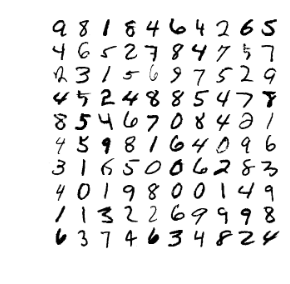

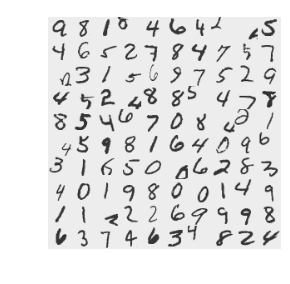

In [13]:
seed = 10102016 
rng = np.random.RandomState(seed)


def show_batch_of_images(img_batch, fig_size=(3, 3)):
    fig = plt.figure(figsize=fig_size)
    batch_size, im_height, im_width = img_batch.shape
    # calculate no. columns per grid row to give square grid
    grid_size = int(batch_size**0.5)
    # intialise empty array to tile image grid into
    tiled = np.empty((im_height * grid_size, 
                      im_width * batch_size // grid_size))
    # iterate over images in batch + indexes within batch
    for i, img in enumerate(img_batch):
        # calculate grid row and column indices
        r, c = i % grid_size, i // grid_size
        tiled[r * im_height:(r + 1) * im_height, 
              c * im_height:(c + 1) * im_height] = img
    ax = fig.add_subplot(111)
    ax.imshow(tiled, cmap='Greys') #, vmin=0., vmax=1.)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    return fig, ax

test_data = MNISTDataProvider('test', 100, rng=rng)
inputs, targets = test_data.next()
_ = show_batch_of_images(inputs.reshape((-1, 28, 28)))
transformed_inputs = random_shift_6(inputs, rng)
_ = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)))

In [32]:


models = []
seed = 10102016 
rng = np.random.RandomState(seed)
input_dim, output_dim, hidden_dim = 784, 10, 100
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)


data_sets = [
    (MNISTDataProvider('train', batch_size, rng=rng),'no Aug'),
    #(AugmentedMNISTDataProvider('train', rng=rng, transformer=random_rotation),'rotation'),
    (AugmentedMNISTDataProvider('train', rng=rng, transformer=random_shift_1),'shift 1'),
    #(AugmentedMNISTDataProvider('train', rng=rng, transformer=random_shift_3),'shift 3'),
    #(AugmentedMNISTDataProvider('train', rng=rng, transformer=random_shift_6),'shift 6')
    #(AugmentedMNISTDataProvider('train', rng=rng, transformer=random_noise_tiny),'noise 0.01'),
    (AugmentedMNISTDataProvider('train', rng=rng, transformer=random_noise_medium),'noise 0.05'),
    #(AugmentedMNISTDataProvider('train', rng=rng, transformer=random_noise_large),'noise 0.2')
    #(AugmentedMNISTDataProvider('train', rng=rng, transformer=random_zoom_tiny),'zoom 0.01'),
    #(AugmentedMNISTDataProvider('train', rng=rng, transformer=random_zoom_medium),'zoom 0.05'),
    (AugmentedMNISTDataProvider('train', rng=rng, transformer=random_zoom_large),'zoom 0.2'),
    (AugmentedMNISTDataProvider('train', rng=rng, transformer=random_mix),'combination zoom+shift')

    
]
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)


run_info = OrderedDict()
models = OrderedDict()
for idx, train_data in enumerate(data_sets):
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    label = train_data[1]
    train_data[0].reset()
    valid_data.reset()
    print ("Run "+str(label))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])
    error = CrossEntropySoftmaxError()
    learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    
    optimiser = Optimiser(model, error, learning_rule, train_data[0], valid_data, data_monitors)
    run_info[label] = optimiser.train(num_epochs, stats_interval)
    models[label] = model






Run no Aug
Epoch: 5    OrderedDict([('error(train)', 0.1152658061596873), ('acc(train)', 0.96688000000000263), ('error(valid)', 0.12518692433288847), ('acc(valid)', 0.96479999999999977), ('params_penalty', 0.0)])
Epoch: 10    OrderedDict([('error(train)', 0.053010007501050359), ('acc(train)', 0.98586000000000407), ('error(valid)', 0.088170301896959097), ('acc(valid)', 0.97319999999999951), ('params_penalty', 0.0)])
Epoch: 15    OrderedDict([('error(train)', 0.034634204609331198), ('acc(train)', 0.9903600000000039), ('error(valid)', 0.084799496857764556), ('acc(valid)', 0.97429999999999894), ('params_penalty', 0.0)])
Epoch: 20    OrderedDict([('error(train)', 0.018089164499833128), ('acc(train)', 0.99626000000000203), ('error(valid)', 0.081988401889192208), ('acc(valid)', 0.97639999999999982), ('params_penalty', 0.0)])
Epoch: 25    OrderedDict([('error(train)', 0.010275747222676912), ('acc(train)', 0.99864000000000064), ('error(valid)', 0.08367737331792649), ('acc(valid)', 0.97569999999

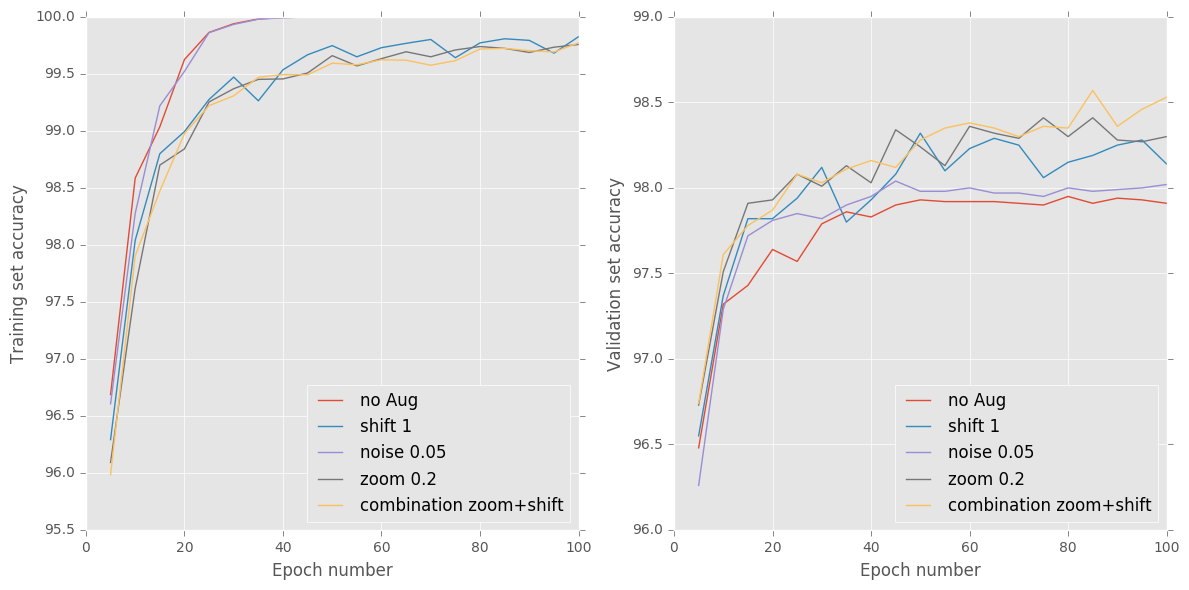

In [33]:

%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for label,run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(train)']]*100, label=str(label))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(valid)']]*100, label=str(label))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set accuracy')
#ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')
#ax2.set_yscale('log')
fig.tight_layout() # This minimises whitespace around the axes.
fig.savefig('comb_compare.pdf') # Save figure to current directory in PDF format

In [18]:
#no augmentation
train_data = MNISTDataProvider('train', batch_size, rng=rng)
optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

no_aug_stats, no_aug_keys, no_aug_run_time = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)


Epoch: 5    OrderedDict([('error(train)', 0.029557090481722798), ('acc(train)', 0.99272000000000393), ('error(valid)', 0.07284149918156213), ('acc(valid)', 0.97779999999999945), ('params_penalty', 0.0)])
Epoch: 10    OrderedDict([('error(train)', 0.017190819307491677), ('acc(train)', 0.99644000000000177), ('error(valid)', 0.076467051894945931), ('acc(valid)', 0.97839999999999916), ('params_penalty', 0.0)])


In [22]:
ax1.plot(np.arange(1, no_aug_stats.shape[0]) * stats_interval, 
         no_aug_stats[1:,no_aug_keys['error(train)']], label='No augmentation')
ax2.plot(np.arange(1, no_aug_stats.shape[0]) * stats_interval, 
         no_aug_stats[1:, no_aug_keys['error(valid)']], label='No augmentation')
plt.show()

## Part 3: Batch normalization

In [ ]:
models = []
seed = 10102016 
rng = np.random.RandomState(seed)
input_dim, output_dim, hidden_dim = 784, 10, 100
batch_size = 100
num_epochs = 100
learning_rate = 0.1
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)




model_sets = [
    (MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init),
    ]),100),
    (MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        Batch(hidden_dim,20),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        Batch(hidden_dim,20),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init),
    ]),20),
    (MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        Batch(hidden_dim,50),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        Batch(hidden_dim,50),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init),
    ]),50),
    (MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        Batch(hidden_dim,100),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        Batch(hidden_dim,100),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init),
    ]),100),
    (MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        Batch(hidden_dim,500),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        Batch(hidden_dim,500),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init),
    ]),500)
]



    
run_info = OrderedDict()
for idx, model in enumerate(model_sets):
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    bs = model[1]
    rng.seed(seed)
    train_data = MNISTDataProvider('train', bs, rng=rng)
    valid_data = MNISTDataProvider('valid', bs, rng=rng)

    train_data.reset()
    valid_data.reset()
    label = ''
    if (idx==0):
        label = ' Baseline'
    print ("Run "+str(bs))

    error = CrossEntropySoftmaxError()
    learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    optimiser = Optimiser(model[0], error, learning_rule, train_data, valid_data, data_monitors)
    run_info[str(bs)+label] = optimiser.train(num_epochs, stats_interval)



Run 100
Epoch: 5    OrderedDict([('error(train)', 0.047822928768334758), ('acc(train)', 0.98470000000000502), ('error(valid)', 0.097647423500727304), ('acc(valid)', 0.97069999999999945), ('params_penalty', 0.0)])
Epoch: 10    OrderedDict([('error(train)', 0.020315316099136307), ('acc(train)', 0.99358000000000313), ('error(valid)', 0.09986035983913355), ('acc(valid)', 0.97389999999999977), ('params_penalty', 0.0)])
Epoch: 15    OrderedDict([('error(train)', 0.019891987294491046), ('acc(train)', 0.99342000000000319), ('error(valid)', 0.12754919983668794), ('acc(valid)', 0.97469999999999957), ('params_penalty', 0.0)])
Epoch: 20    OrderedDict([('error(train)', 0.011878797955756658), ('acc(train)', 0.99584000000000239), ('error(valid)', 0.14638496268219059), ('acc(valid)', 0.97559999999999936), ('params_penalty', 0.0)])
Epoch: 25    OrderedDict([('error(train)', 0.014658553597139516), ('acc(train)', 0.99548000000000192), ('error(valid)', 0.15315595834191989), ('acc(valid)', 0.9759999999999

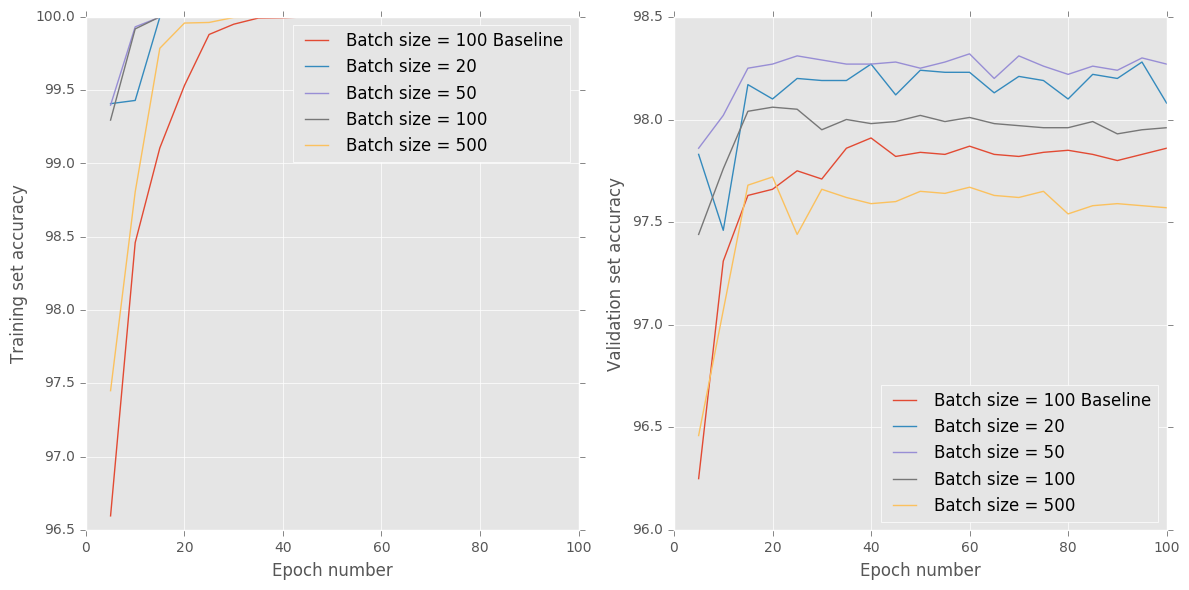

In [4]:

%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for bs,run in run_info.items():
    stats, keys, run_time = run

    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(train)']]*100, label='Batch size = '+str(bs))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(valid)']]*100, label='Batch size = '+str(bs))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set accuracy')
#ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')
#ax2.set_yscale('log')
fig.tight_layout() # This minimises whitespace around the axes.
fig.savefig('batch_compare_rate.pdf') # Save figure to current directory in PDF format